In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0604/weights_KD_segformer_0604_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.6
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0135

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step - loss: 0.0089
Average validation loss: 0.600648045539856
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step - loss: 0.0089 - val_loss: 0.6006
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 800ms/step - loss: 0.0056 - val_loss: 0.6006
Average validation loss: 0.5823676586151123
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 812ms/step - loss: 0.0056 - val_loss: 0.5915
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 859ms/step - loss: 0.0039 - val_loss: 0.5915
Average validation loss: 0.4749341607093811
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 871ms/step - loss: 0.0039 - val_loss: 0.5526
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segf

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 776ms/step - loss: 4.2870e-06
Average validation loss: 0.18213006108999252
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 788ms/step - loss: 4.2870e-06 - val_loss: 0.1821
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 776ms/step - loss: 4.1470e-06 - val_loss: 0.1821
Average validation loss: 0.09109271876513958
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 788ms/step - loss: 4.1470e-06 - val_loss: 0.1366
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 779ms/step - loss: 3.9695e-06 - val_loss: 0.1366
Average validation loss: 0.2101832628250122
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 790ms/step - loss: 3.9695e-06 - val_loss: 0.1611
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 772ms/step - loss: 3.8617e-06 - val_loss: 0

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 781ms/step - loss: 1.6981e-06
Average validation loss: 0.08965581158796947
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 793ms/step - loss: 1.6981e-06 - val_loss: 0.0897
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 841ms/step - loss: 1.7272e-06 - val_loss: 0.0897
Average validation loss: 0.09871898715694745
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 853ms/step - loss: 1.7272e-06 - val_loss: 0.0942
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 778ms/step - loss: 1.6909e-06 - val_loss: 0.0942
Average validation loss: 0.08065386985739072
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 789ms/step - loss: 1.6909e-06 - val_loss: 0.0897
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_15.pth'.
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 39s 777ms/step - loss: 1.5458e

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 768ms/step - loss: 4.8256e-07
Average validation loss: 0.03187863924540579
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 779ms/step - loss: 4.8256e-07 - val_loss: 0.0319
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 788ms/step - loss: 4.2027e-07 - val_loss: 0.0319
Average validation loss: 0.022383881616406143
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 798ms/step - loss: 4.2027e-07 - val_loss: 0.0271
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_20.pth'.
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 818ms/step - loss: 3.9064e-07 - val_loss: 0.0271
Average validation loss: 0.027953913435339928
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 828ms/step - loss: 3.9064e-07 - val_loss: 0.0274
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 52s 818ms/step - loss: 3.634

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 826ms/step - loss: 3.4105e-07
Average validation loss: 0.0183426212053746
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 839ms/step - loss: 3.4105e-07 - val_loss: 0.0183
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 783ms/step - loss: 3.0687e-07 - val_loss: 0.0183
Average validation loss: 0.024807191267609597
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 797ms/step - loss: 3.0687e-07 - val_loss: 0.0216
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 777ms/step - loss: 2.7045e-07 - val_loss: 0.0216
Average validation loss: 0.01715374826453626
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 788ms/step - loss: 2.7045e-07 - val_loss: 0.0201
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_25.pth'.
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 66s 855ms/step - loss: 2.6270e

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 777ms/step - loss: 4.7809e-07
Average validation loss: 0.012365665344987065
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 787ms/step - loss: 4.7809e-07 - val_loss: 0.0124
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 778ms/step - loss: 4.0287e-07 - val_loss: 0.0124
Average validation loss: 0.014267412344149003
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 788ms/step - loss: 4.0287e-07 - val_loss: 0.0133
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 57s 778ms/step - loss: 3.3279e-07 - val_loss: 0.0133
Average validation loss: 0.010478205338586122
24/24 ━━━━━━━━━━━━━━━━━━━━ 57s 789ms/step - loss: 3.3279e-07 - val_loss: 0.0124
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_30.pth'.
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 76s 788ms/step - loss: 2.89

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 33s 834ms/step - loss: 2.0980e-06
Average validation loss: 0.06580224873032421
40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 847ms/step - loss: 2.0980e-06 - val_loss: 0.0658
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 65s 777ms/step - loss: 1.5698e-06 - val_loss: 0.0658
Average validation loss: 0.08108681184239686
40/40 ━━━━━━━━━━━━━━━━━━━━ 65s 789ms/step - loss: 1.5698e-06 - val_loss: 0.0734
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 97s 779ms/step - loss: 1.3789e-06 - val_loss: 0.0734
Average validation loss: 0.049809396150521934
40/40 ━━━━━━━━━━━━━━━━━━━━ 97s 791ms/step - loss: 1.3789e-06 - val_loss: 0.0656
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_50.pth'.
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 128s 779ms/step - loss: 1.201

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 42s 873ms/step - loss: 2.5125e-07
Average validation loss: 0.009623345259266594
48/48 ━━━━━━━━━━━━━━━━━━━━ 42s 884ms/step - loss: 2.5125e-07 - val_loss: 0.0096
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 80s 791ms/step - loss: 2.0092e-07 - val_loss: 0.0096
Average validation loss: 0.010534947117169699
48/48 ━━━━━━━━━━━━━━━━━━━━ 81s 802ms/step - loss: 2.0092e-07 - val_loss: 0.0101
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 119s 797ms/step - loss: 1.7262e-07 - val_loss: 0.0101
Average validation loss: 0.010770536357692132
48/48 ━━━━━━━━━━━━━━━━━━━━ 120s 808ms/step - loss: 1.7262e-07 - val_loss: 0.0103
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 158s 801ms/step - loss: 1.5104e-07 - val_loss: 0.0103
Average validation loss: 0.008438178958992163
48/48 ━━━━━━━━━━━━━━━━━━━━ 159s 813ms/step - loss: 1.5104e-07 - val_loss: 0.0098
S

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 821ms/step - loss: 1.1913e-07
Average validation loss: 0.015506571225289787
56/56 ━━━━━━━━━━━━━━━━━━━━ 47s 833ms/step - loss: 1.1913e-07 - val_loss: 0.0155
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 94s 845ms/step - loss: 1.1056e-07 - val_loss: 0.0155
Average validation loss: 0.019523998722434044
56/56 ━━━━━━━━━━━━━━━━━━━━ 95s 857ms/step - loss: 1.1056e-07 - val_loss: 0.0175
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 143s 857ms/step - loss: 1.1522e-07 - val_loss: 0.0175
Average validation loss: 0.01409153307655028
56/56 ━━━━━━━━━━━━━━━━━━━━ 143s 868ms/step - loss: 1.1522e-07 - val_loss: 0.0164
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_70.pth'.
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 190s 827ms/step - loss: 1.

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 798ms/step - loss: 1.2639e-07
Average validation loss: 0.014224111655494198
64/64 ━━━━━━━━━━━━━━━━━━━━ 52s 809ms/step - loss: 1.2639e-07 - val_loss: 0.0142
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 102s 785ms/step - loss: 1.0528e-07 - val_loss: 0.0142
Average validation loss: 0.0114143965911353
64/64 ━━━━━━━━━━━━━━━━━━━━ 103s 796ms/step - loss: 1.0528e-07 - val_loss: 0.0128
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 154s 803ms/step - loss: 9.7857e-08 - val_loss: 0.0128
Average validation loss: 0.012603711773408577
64/64 ━━━━━━━━━━━━━━━━━━━━ 155s 814ms/step - loss: 9.7857e-08 - val_loss: 0.0127
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 206s 802ms/step - loss: 8

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 792ms/step - loss: 7.7933e-08
Average validation loss: 0.01765195801595433
72/72 ━━━━━━━━━━━━━━━━━━━━ 58s 803ms/step - loss: 7.7933e-08 - val_loss: 0.0177
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 114s 782ms/step - loss: 6.2551e-08 - val_loss: 0.0177
Average validation loss: 0.020238633587723598
72/72 ━━━━━━━━━━━━━━━━━━━━ 115s 793ms/step - loss: 6.2551e-08 - val_loss: 0.0189
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 172s 798ms/step - loss: 5.8036e-08 - val_loss: 0.0189
Average validation loss: 0.017441873367513634
72/72 ━━━━━━━━━━━━━━━━━━━━ 173s 809ms/step - loss: 5.8036e-08 - val_loss: 0.0184
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_90.pth'.
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 232s 814ms/step - loss: 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 789ms/step - loss: 6.4781e-08
Average validation loss: 0.007911062678613235
80/80 ━━━━━━━━━━━━━━━━━━━━ 64s 800ms/step - loss: 6.4781e-08 - val_loss: 0.0079
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 128s 805ms/step - loss: 5.6542e-08 - val_loss: 0.0079
Average validation loss: 0.009717495323275215
80/80 ━━━━━━━━━━━━━━━━━━━━ 129s 815ms/step - loss: 5.6542e-08 - val_loss: 0.0088
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 201s 891ms/step - loss: 5.0627e-08 - val_loss: 0.0088
Average validation loss: 0.01075907819904387
80/80 ━━━━━━━━━━━━━━━━━━━━ 202s 902ms/step - loss: 5.0627e-08 - val_loss: 0.0095
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 269s 845ms/step - loss: 4.6879e-08 - val_loss: 0.0095
Average validation loss: 0.011321498149482068
80/80 ━━━━━━━━━━━━━━━━━━━━ 270s 856ms/step - loss: 4.6879e-08 - val_loss: 0.0099

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 78s 808ms/step - loss: 1.8147e-07
Average validation loss: 0.02373767343427365
96/96 ━━━━━━━━━━━━━━━━━━━━ 79s 820ms/step - loss: 1.8147e-07 - val_loss: 0.0237
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 154s 780ms/step - loss: 1.3832e-07 - val_loss: 0.0237
Average validation loss: 0.024190520101304475
96/96 ━━━━━━━━━━━━━━━━━━━━ 155s 791ms/step - loss: 1.3832e-07 - val_loss: 0.0240
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 230s 779ms/step - loss: 1.2243e-07 - val_loss: 0.0240
Average validation loss: 0.025552986655384302
96/96 ━━━━━━━━━━━━━━━━━━━━ 231s 790ms/step - loss: 1.2243e-07 - val_loss: 0.0245
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 305s 772ms/step - loss: 1.0955e-07 - val_loss: 0.0245
Average validation loss: 0.0224931802173766
96/96 ━━━━━━━━━━━━━━━━━━━━ 306s 784ms/step - loss: 1.0955e-07 - val_loss: 0.0240
S

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 95s 796ms/step - loss: 3.0544e-07
Average validation loss: 0.018322225000398856
120/120 ━━━━━━━━━━━━━━━━━━━━ 97s 807ms/step - loss: 3.0544e-07 - val_loss: 0.0183
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 192s 795ms/step - loss: 2.1597e-07 - val_loss: 0.0183
Average validation loss: 0.024167212808970363
120/120 ━━━━━━━━━━━━━━━━━━━━ 194s 806ms/step - loss: 2.1597e-07 - val_loss: 0.0212
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 288s 786ms/step - loss: 1.7297e-07 - val_loss: 0.0212
Average validation loss: 0.017451161922266086
120/120 ━━━━━━━━━━━━━━━━━━━━ 289s 797ms/step - loss: 1.7297e-07 - val_loss: 0.0200
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_150.pth'.
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 385s 79

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 113s 785ms/step - loss: 1.8824e-07
Average validation loss: 0.02928776368046076
144/144 ━━━━━━━━━━━━━━━━━━━━ 115s 796ms/step - loss: 1.8824e-07 - val_loss: 0.0293
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 231s 803ms/step - loss: 1.3910e-07 - val_loss: 0.0293
Average validation loss: 0.02349599017179571
144/144 ━━━━━━━━━━━━━━━━━━━━ 232s 814ms/step - loss: 1.3910e-07 - val_loss: 0.0264
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 348s 802ms/step - loss: 1.1519e-07 - val_loss: 0.0264
Average validation loss: 0.027544032159817614
144/144 ━━━━━━━━━━━━━━━━━━━━ 349s 812ms/step - loss: 1.1519e-07 - val_loss: 0.0268
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 463s 78

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 130s 814ms/step - loss: 8.8433e-08
Average validation loss: 0.024130003049504013
160/160 ━━━━━━━━━━━━━━━━━━━━ 132s 825ms/step - loss: 8.8433e-08 - val_loss: 0.0241
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 261s 809ms/step - loss: 7.0743e-08 - val_loss: 0.0241
Average validation loss: 0.019574940559687094
160/160 ━━━━━━━━━━━━━━━━━━━━ 263s 820ms/step - loss: 7.0743e-08 - val_loss: 0.0219
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 391s 798ms/step - loss: 6.0007e-08 - val_loss: 0.0219
Average validation loss: 0.020190689087030478
160/160 ━━━━━━━━━━━━━━━━━━━━ 393s 809ms/step - loss: 6.0007e-08 - val_loss: 0.0213
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 531s 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 163s 815ms/step - loss: 1.0919e-07
Average validation loss: 0.018765619098849128
200/200 ━━━━━━━━━━━━━━━━━━━━ 165s 826ms/step - loss: 1.0919e-07 - val_loss: 0.0188
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 323s 787ms/step - loss: 9.6871e-08 - val_loss: 0.0188
Average validation loss: 0.03007542068749899
200/200 ━━━━━━━━━━━━━━━━━━━━ 325s 798ms/step - loss: 9.6871e-08 - val_loss: 0.0244
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 484s 794ms/step - loss: 8.2043e-08 - val_loss: 0.0244
Average validation loss: 0.026225140231545083
200/200 ━━━━━━━━━━━━━━━━━━━━ 486s 805ms/step - loss: 8.2043e-08 - val_loss: 0.0250
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 642s 779ms/step - loss: 7.1742e-08 - val_loss: 0.0250
Average validation loss: 0.02306978873180924
200/200 ━━━━━━━━━━━━━━━━━━━━ 644s 790ms/step - loss: 7.1742e-08 -

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 191s 795ms/step - loss: 7.8197e-08
Average validation loss: 0.02157882439957272
240/240 ━━━━━━━━━━━━━━━━━━━━ 193s 806ms/step - loss: 7.8197e-08 - val_loss: 0.0216
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 381s 780ms/step - loss: 6.3618e-08 - val_loss: 0.0216
Average validation loss: 0.021508011032165087
240/240 ━━━━━━━━━━━━━━━━━━━━ 383s 791ms/step - loss: 6.3618e-08 - val_loss: 0.0215
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_60\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 569s 775ms/step - loss: 5.4208e-08 - val_loss: 0.0215
Average validation loss: 0.017194719775640504
240/240 ━━━━━━━━━━━━━━━━━━━━ 572s 786ms/step - loss: 5.4208e-08 - val_loss: 0.0201
Saved model weights to 'c:\天_11157065\git\Ripp

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.20450405783951284, 0.115555424913764, 0.04108550143117706, 0.023772969209239818, 0.012732953353086487, 0.015035654714059397, 0.0195298897101311, 0.010635867226519623, 0.009703768046123775, 0.011303196267908789, 0.01173913561777833, 0.01318360355691402, 0.01640694109604131, 0.018326053699633728, 0.02179342190661474, 0.019943209998687962, 0.021228117263864258, 0.01859458255151185]
std_val_losses =  [0.13118113468418036, 0.08693623686489473, 0.020635563510725555, 0.013528498427346642, 0.0046273626681143185, 0.020740933910332462, 0.013475396563340942, 0.0023635868433819, 0.0033857491662860023, 0.00331516905869665, 0.004382034021623951, 0.005733895218340617, 0.005219661995795342, 0.003646227306773902, 0.0041594406848968766, 0.0034112755830022004, 0.004767263506764196, 0.002995516655554758]


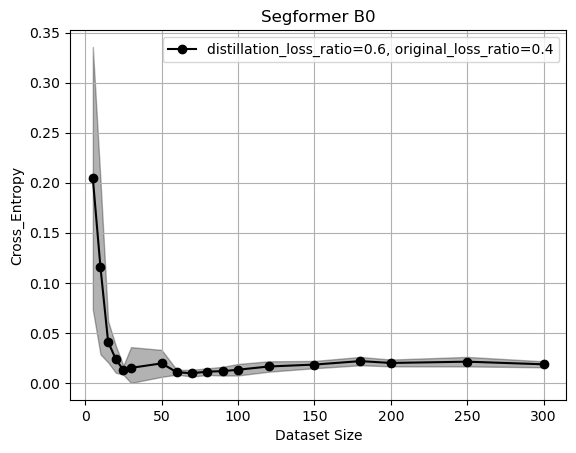

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0604')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.png"))

plt.show()